<a href="https://colab.research.google.com/github/EmmaKLofthouse/vegetable_identifier/blob/transfer_learning/transfer_inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


# VegVision: Neural Network Vegetable Classifier

> This notebook contains code for development of a model using transfer learning



# Load modules

In [24]:
!pip3 install split_folders

In [170]:
# General
import splitfolders
import numpy as np
import os
from glob import glob
import cv2

# TensorFlow
import tensorflow as tf
from tf.compat.v1 import ConfigProto
from tf.compat.v1 import InteractiveSession
from tf.keras.layers import Input, Lambda, Dense, Flatten
from tf.keras.models import Model, load_model
from tf.keras.preprocessing import image
from tf.keras.preprocessing.image import ImageDataGenerator,load_img
from tf.keras.models import Sequential

# Metrics
from keras.metrics import Accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Pre-trained Models
from tf.keras.applications.inception_v3 import InceptionV3

#Plotting
import matplotlib.pyplot as plt

RANDOM_STATE = 42

In [171]:
# Set up GPU
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


# Split data

In [172]:
raw_dir = '/content/drive/MyDrive/Projects/vegetable_identifier/train'
output = "/content/drive/MyDrive/Projects/vegetable_identifier/transfer"

splitfolders.ratio(raw_dir, output=output, seed=42, ratio=(0.7,0.3))

Copying files: 1208 files [00:36, 33.00 files/s]


# Load Pre-trained Model

In [173]:
IMAGE_SIZE = [224, 224]
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [175]:
# don't train existing weights
for layer in inception.layers:
   layer.trainable = False

# Create our model

In [180]:
train_dir = '/content/drive/MyDrive/Projects/vegetable_identifier/transfer/train'
valid_dir = '/content/drive/MyDrive/Projects/vegetable_identifier/transfer/val'

In [181]:
x = Flatten()(inception.output)

In [182]:
# Set output layer and add to model
categories = os.listdir(train_dir)
output_layer = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=output_layer)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [183]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [184]:
# Set up samples and apply augmentation to training data
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255)

In [194]:
# Make sure you provide the same target size as initialied for the image size
train = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 841 images belonging to 8 classes.


In [195]:
val = val_datagen.flow_from_directory(valid_dir,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 365 images belonging to 8 classes.


In [196]:
# Set up tracking
log_dir = '/content/drive/MyDrive/Projects/vegetable_identifier/logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
hist = model.fit(train,
                epochs=10,
                validation_data=val,
                callbacks=[tensorboard_callback])

# Evaluate Model Performance

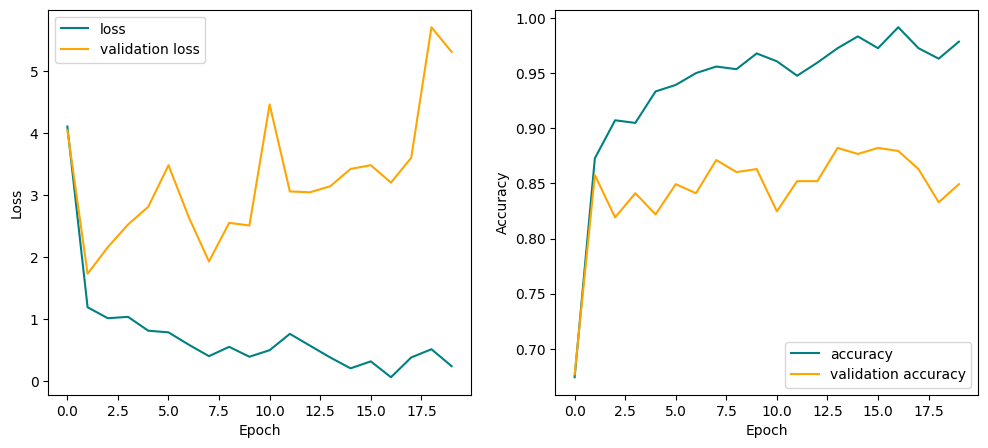

In [53]:
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='validation loss')
plt.legend(loc='best')
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='validation accuracy')
plt.legend(loc='best')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

Note that the model is overfitting!

# Test on unseen data

In [59]:
test_dir = '/content/drive/MyDrive/Projects/vegetable_identifier/test/'
test_datagen = ImageDataGenerator(rescale = 1./255)
test = test_datagen.flow_from_directory(test_dir,
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        class_mode = 'categorical')

Found 139 images belonging to 8 classes.


1/1 [==============================] - 3s 3s/step


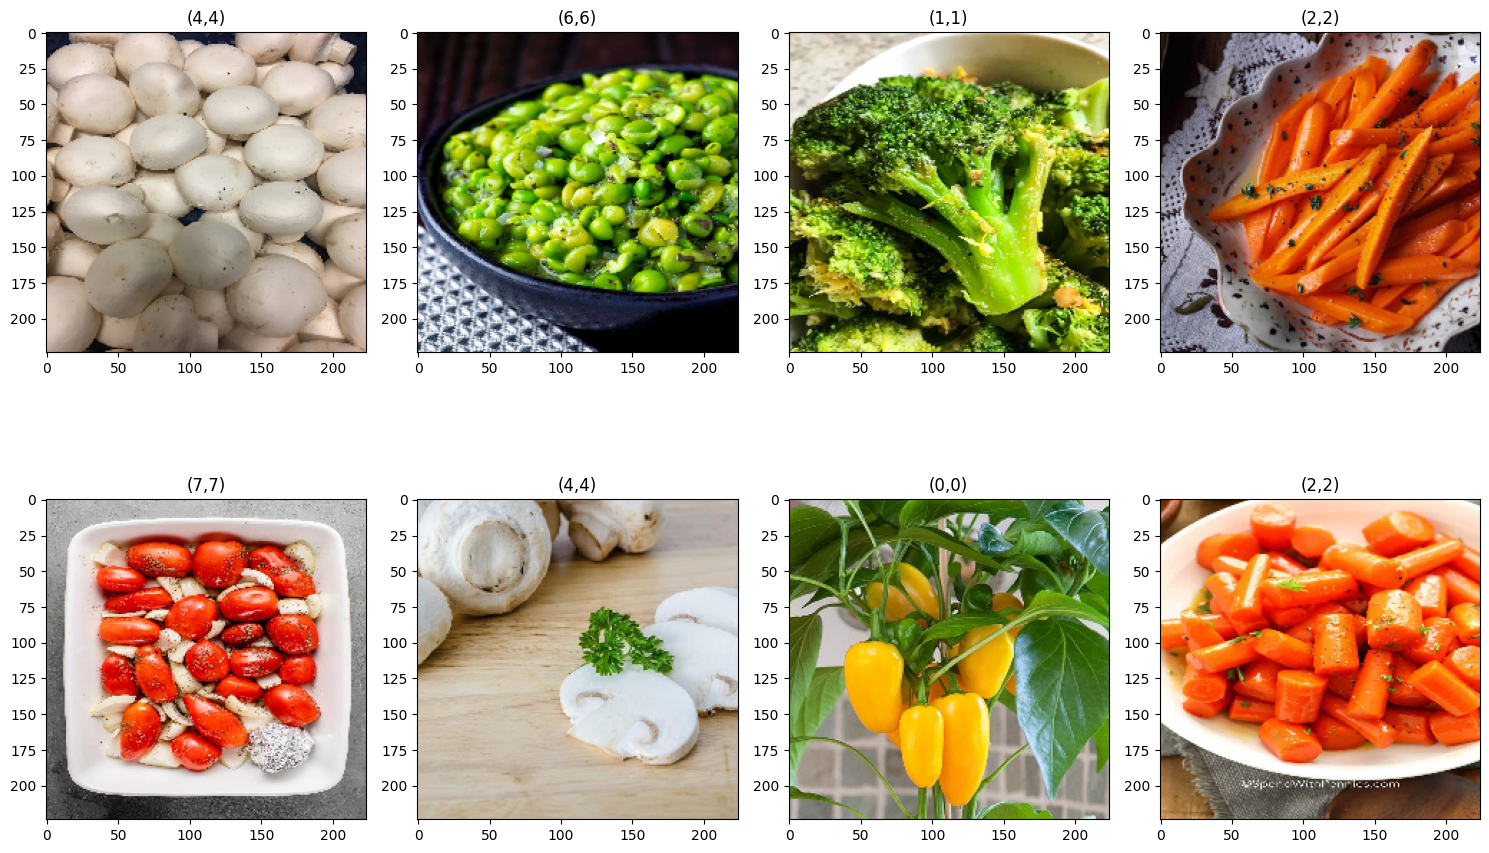

In [65]:
batch = test.next()
X, y = batch
preds = model.predict(X)

n_plots = 8
plt.figure(figsize=(15, 10))
for idx, img in enumerate(X[:n_plots]):
    plt.subplot(2, n_plots//2, idx+1)
    plt.imshow(img)
    predicted_class = np.argmax(preds[idx])
    plt.title(f"({np.argmax(y[idx])},{predicted_class})")

plt.tight_layout()
plt.show()

In [199]:
predicted_labels = []
true_labels = []

accuracy = Accuracy()

for idx,batch in enumerate(test):#.as_numpy_iterator():

    X, y = batch

    preds_prob = model.predict(X,verbose=False)
    predictions = [np.argmax(i) for i in preds_prob]

    true = [np.argmax(i) for i in y]
    accuracy.update_state(true, predictions)

    true_labels += list(true)
    predicted_labels += predictions

    # Stop the loop after iterating through all batches
    if idx >= len(test) - 1:
        break

print("Results for test data:")
print(f"Accuracy:  {accuracy.result().numpy():.2f}")

Results for test data:
Accuracy:  0.83


# Confusion Matrix

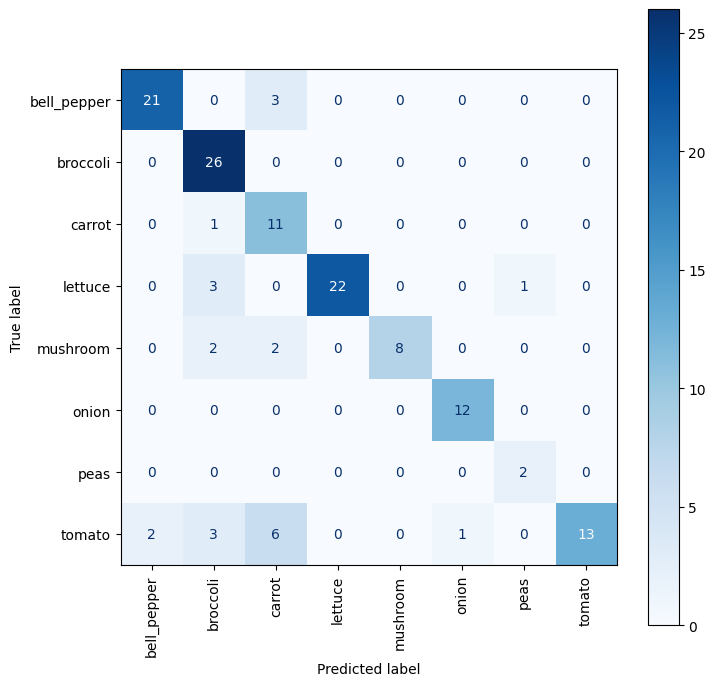

In [201]:
cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()


# Save Model

In [200]:
model_name = 'model_inceptionV3'
model.save(os.path.join('/content/drive/MyDrive/Projects/vegetable_identifier/models',model_name))


# Test on new image

### Load Model

In [95]:
model = load_model(os.path.join('/content/drive/MyDrive/Projects/vegetable_identifier/models',model_name))

### Load Image

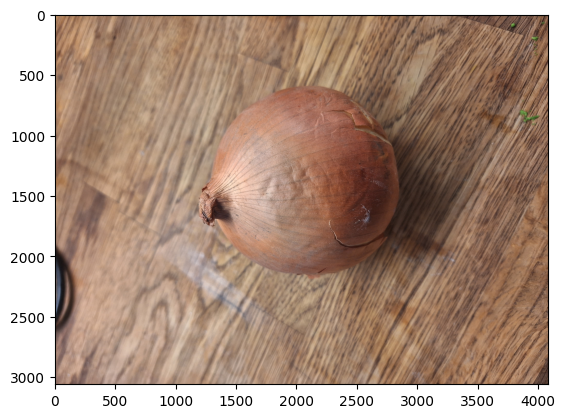

In [164]:
img_path = '/content/drive/MyDrive/Projects/vegetable_identifier/new_test_images/20240305_154531.jpg'
plt.imshow(image.load_img(img_path))
plt.show()

### Predict class

In [204]:
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img, (224,224))
predicted_probs = model.predict(np.expand_dims(resize/255, 0), verbose=False)
predicted_class = np.argmax(predicted_probs)
print(f"Predicted class is {categories[predicted_class]}")

Predicted class is onion
